# Detroit Land Bank Authority (DLBA) Boarding Model

Geoff Perrin - 01.16.18

- This notebook is to predict whether or not a (single family residential) house in Detroit should be boarded by the city or not, based on historical boarding decisions made by the city (i.e. labelled data I've receieved from the Detroit Land Bank Authority (DLBA) in the form of housing surveys, as well as the Motor City Mapping housing survey done in 2014-2016.

In [1]:
#import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(222)
%matplotlib inline

In [2]:
#import machine learning / classification libraries
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RFC
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import losses,optimizers,metrics,activations
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [5]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

### Load Datasets

In [8]:
data = '../data/OccModelTrainingData_20170901/'
data_gtj = '../data/'

#### GTJ Survey Data

GTP Note 1-16-18: 

one strategy is to use GTJ data as labelled data - if "GTJ Property Secure" is "No", then boarding is needed.

In [92]:
gtj_df = pd.read_csv(data_gtj + 'MostRecentGTJSurvey_20180112.csv')

In [93]:
gtj_df[gtj_df['Parcel ID']=='22033549.']

,Address,Neighborhood,Parcel ID,Property: Property Class,Property: Property Ownership,Property: Program,Status,GTJ Photo Link,GTJ Survey Complete,GTJ Structure,GTJ Structure Type,GTJ Occupancy,GTJ Property Secure,GTJ Survey Assessment,GTJ Structure Condition,GTJ Foundation Condition,GTJ Roof Condition,GTJ Overall Condition,GTJ Notes
6,18410 Stansbury,Winship,22033549.,Residential-Structure,Under Compliance,Auction,Compliance (Sales),NaN,3/20/2017,Yes,Single Family,Vacant,NaN,NaN,NaN,NaN,NaN,Fair,Extensive fire damages present at the rear hal...


In [94]:
gtj_df = gtj_df[['Parcel ID', 'Property: Property Class', 'Property: Program', 'Status', 'GTJ Survey Complete', 'GTJ Property Secure']]

In [95]:
gtj_df.columns = ['Ref_ID', 'property_class', 'program', 'status', 'survey_complete_date', 'boarding_needed']

In [96]:
gtj_df['survey_complete_date'] = gtj_df['survey_complete_date'].apply(pd.to_datetime)

In [97]:
def year_date(x):
    return x.year

In [98]:
#just subset to houses surveyed since beginning of 2016
gtj_df['year'] = gtj_df['survey_complete_date'].apply(year_date)
gtj_df = gtj_df[gtj_df.year >= 2016]

In [99]:
#subset to just residential-structures
gtj_df = gtj_df[gtj_df['property_class'] == 'Residential-Structure']

In [100]:
gtj_df.groupby(['year'], as_index=False)['Ref_ID'].count()

,year,Ref_ID
0,2016.0,14677
1,2017.0,7161


In [102]:
def boarding_needed_flag(x):
    if x=='Yes':
        return 1
    else:
        return 0

In [103]:
gtj_df['boarding_needed_dummy'] = gtj_df['boarding_needed'].apply(boarding_needed_flag)

In [104]:
#final subset to just the columns we need
gtj_df = gtj_df[['Ref_ID', 'boarding_needed_dummy']]

#### DTE data

In [37]:
dte_df = pd.read_csv(data + 'DTE_ActiveGasElectric_GeocoderMatches_20170920.txt')

In [38]:
dte_df = dte_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [39]:
### Deduplicate data
dte_df = dte_df.drop_duplicates()

In [40]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df = dte_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

#### DWSD (Water Department) data

In [41]:
dwsd_df = pd.read_csv(data + 'DWSD_12Mo_20170825.csv')

In [42]:
dwsd_df = dwsd_df[[u'REPAIREDPARCELID',
                   u'NINE', u'TEN', u'ELEVEN',
                   u'TWELVE', u'ONE', u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',
                   u'EIGHT']]

In [43]:
def pandas_to_numeric(s):
    s = s.str.replace(',', '')
    return pd.to_numeric(s, errors='coerce')

In [44]:
dwsd_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', u'TWO', u'THREE', \
              u'FOUR', u'FIVE', u'SIX', u'SEVEN',u'EIGHT']] \
            = dwsd_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', \
                            u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',\
                            u'EIGHT']].apply(pandas_to_numeric)

In [45]:
dwsd_df['year_total'] = dwsd_df.ONE + dwsd_df.TWO + dwsd_df.THREE + dwsd_df.FOUR +\
                        dwsd_df.FIVE + dwsd_df.SIX +dwsd_df.SEVEN + dwsd_df.EIGHT + dwsd_df.NINE +\
                        dwsd_df.TEN + dwsd_df.ELEVEN + dwsd_df.TWELVE

In [46]:
### sum water amounts of duplicate properties 
dwsd_df = dwsd_df.groupby(['REPAIREDPARCELID'], as_index=False)[ 
        u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', 
        u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', 
        u'SEVEN', u'EIGHT', u'year_total'].sum()

In [47]:
dwsd_df = dwsd_df.rename(columns={'REPAIREDPARCELID': 'Ref_ID'})

#### USPS / DFD (Fire Department) data

In [48]:
usps_df = pd.read_csv(data + 'DFD_USPS_20170829.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
usps_df.head()

,Account Name,Parcel ID,Property Class,USPS: Last Update,USPS: Vacancy Indicated,DFD Fire: Occurrence Date
0,2411 Wendell,20007595.,Residential-Structure,8/1/2017,No,8/19/2017
1,17208 Ohio,16033858.,Residential-Structure,8/1/2017,No,8/19/2017
2,60 E Euclid,01002534.,Residential-Structure,8/1/2017,No,8/19/2017
3,8154 W Lafayette,20002305.,Residential-Structure,8/1/2017,Yes,8/19/2017
4,16691 Fairmount Dr,21025509.001,Residential-Structure,8/1/2017,No,8/18/2017


In [50]:
usps_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date']

In [51]:
### subset to residential data
usps_df = usps_df[usps_df['Property Class'] == 'Residential-Structure']

In [52]:
### create DFD fire dummy
usps_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_df['DFD Fire: Occurrence Date']]

In [53]:
### create USPS occupied dummy
usps_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_df['USPS: Vacancy Indicated']]

In [54]:
### Just keep variables we need
usps_df = usps_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [55]:
vote_df = pd.read_csv(data + 'QVF_Detroit_Geo_20170717.txt')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
vote_df = vote_df[['Ref_ID']]
vote_df['vote_dummy'] = 1

In [57]:
vote_df = vote_df.drop_duplicates()

#### Blext data (Motor City Mapping data)
- https://motorcitymapping.org/#t=overview&s=detroit&f=all

In [58]:
mcm_df = pd.read_csv(data + 'Recent_Blexts_8_18_16_v2.csv')

In [59]:
mcm_df = mcm_df[[u'Account Name', u'Parcel ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']]

In [60]:
mcm_df.columns = [u'Account Name', u'Ref_ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']

In [61]:
### subset to residential data
mcm_df = mcm_df[mcm_df['Property Class'] == 'Residential-Structure']

In [62]:
### subset to non-lot properties
mcm_df = mcm_df[mcm_df['MCM Structure'] == 'Yes']

In [63]:
len(mcm_df)

64783

#### Note from Alice Hargreaves:

NOTE: code "maybe" or "partial" occupied houses as occupied... Ive googled a lot of the "maybes" and theyre nearly all structually sound --- i.e., someone could occupy it, but someone might not be sleeping there every night - GP line of thinking about 3k rows are "maybe" or "partial" 

(R-code below):

In [67]:
def occupancy_binary(x):
    if (x == "Occupied") | (x == "Unoccupied"):
        return x
    else:
        return "Occupied"

In [68]:
mcm_df['MCM Occupancy'] = mcm_df['MCM Occupancy'].apply(occupancy_binary)

In [69]:
### create DFD fire dummy
mcm_df['mcm_occupancy_dummy'] = [1 if x == 'Occupied' else 0 for x in mcm_df['MCM Occupancy']]

### Merge Datasets together

In [106]:
# merge gtj data with usps / dfd data
merged_train = gtj_df.merge(usps_df, how='left', on='Ref_ID')

In [107]:
#merge on voter (qvf) data
merged_train2 = merged_train.merge(vote_df, how='left', on='Ref_ID')

In [108]:
#fill in NaNs for vote_dummy
merged_train2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_train2['vote_dummy']]

In [109]:
#merge on dwsd data
merged_train3 = merged_train2.merge(dwsd_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_train3.fillna(value=0,inplace=True)

In [110]:
#merge on dte data
merged_train_final = merged_train3.merge(dte_df, how='left', on='Ref_ID')
merged_train_final.fillna(value=0,inplace=True)

In [111]:
merged_train_final.head()

,Ref_ID,boarding_needed_dummy,fire_occured_dummy,usps_occupied_dummy,vote_dummy,NINE,TEN,ELEVEN,TWELVE,ONE,TWO,THREE,FOUR,FIVE,SIX,SEVEN,EIGHT,year_total,gas_dummy,electric_dummy
0,22030396.,1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01004952.,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,16023426.,0,1.0,0.0,1,1000.0,1000.0,1000.0,1000.0,900.0,1100.0,1100.0,900.0,1000.0,900.0,900.0,1100.0,11900.0,0.0,0.0
3,21019661.,1,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,22033549.,0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [112]:
merged_train_final.columns

Index([               u'Ref_ID', u'boarding_needed_dummy',
          u'fire_occured_dummy',   u'usps_occupied_dummy',
                  u'vote_dummy',                  u'NINE',
                         u'TEN',                u'ELEVEN',
                      u'TWELVE',                   u'ONE',
                         u'TWO',                 u'THREE',
                        u'FOUR',                  u'FIVE',
                         u'SIX',                 u'SEVEN',
                       u'EIGHT',            u'year_total',
                   u'gas_dummy',        u'electric_dummy'],
      dtype='object')

In [113]:
len(merged_train_final)

21838

### Visualize Data

In [114]:
data_corr = merged_train_final[['boarding_needed_dummy', u'fire_occured_dummy', 
                                u'usps_occupied_dummy',
                                u'vote_dummy',  u'NINE',                  u'TEN',
                     u'ELEVEN',               u'TWELVE',
                        u'ONE',                  u'TWO',
                      u'THREE',                 u'FOUR',
                       u'FIVE',                  u'SIX',
                      u'SEVEN',                u'EIGHT', u'year_total', u'gas_dummy', u'electric_dummy']]

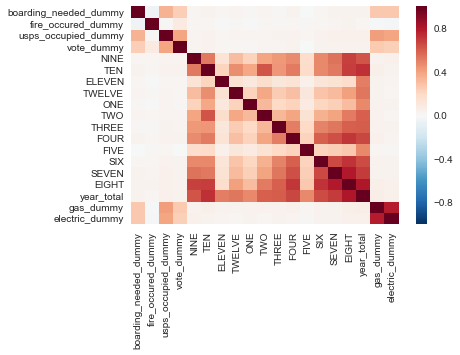

In [115]:
sns.heatmap(data_corr.corr(), annot=False)

In [116]:
data_corr2 = merged_train_final[['boarding_needed_dummy', 
                                 u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy']]

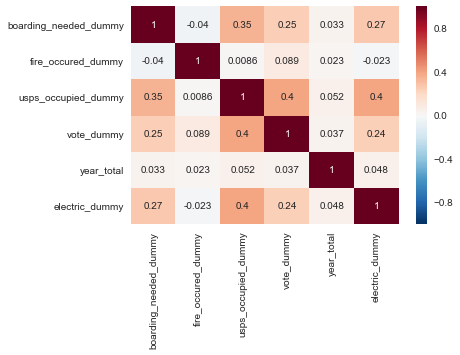

In [117]:
sns.heatmap(data_corr2.corr(), annot=True)

## Classification

In [118]:
merged_train_final.columns

Index([               u'Ref_ID', u'boarding_needed_dummy',
          u'fire_occured_dummy',   u'usps_occupied_dummy',
                  u'vote_dummy',                  u'NINE',
                         u'TEN',                u'ELEVEN',
                      u'TWELVE',                   u'ONE',
                         u'TWO',                 u'THREE',
                        u'FOUR',                  u'FIVE',
                         u'SIX',                 u'SEVEN',
                       u'EIGHT',            u'year_total',
                   u'gas_dummy',        u'electric_dummy'],
      dtype='object')

In [119]:
X = merged_train_final[[u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy']]
y = merged_train_final.boarding_needed_dummy

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=123)

In [122]:
len(X_train)

10700

### Class imbalance correction

In [123]:
merged_train_final.groupby(['boarding_needed_dummy'], as_index=False)['fire_occured_dummy'].count()

,boarding_needed_dummy,fire_occured_dummy
0,0,15318
1,1,6520


### Logistic Classification

In [124]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
predictions = logmodel.predict(X_test)

In [126]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.76      0.94      0.84      4545
          1       0.71      0.33      0.45      2007

avg / total       0.75      0.75      0.72      6552



In [127]:
print(roc_auc_score(y_test, predictions))

0.636164513312


### use Over Sampling to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [128]:
ros = RandomOverSampler(random_state=0, ratio='minority')
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [129]:
sum(y_train)*1.0 / len(y_train)

0.29429906542056072

In [130]:
sum(y_resampled)*1.0 / len(y_resampled)

0.5

In [131]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [132]:
predictions = logmodel.predict(X_test)

In [133]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.77      0.78      4545
          1       0.52      0.56      0.54      2007

avg / total       0.71      0.71      0.71      6552



In [134]:
print(roc_auc_score(y_test, predictions))

0.664721987894


### Use SMOTE to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [135]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [136]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [137]:
predictions = logmodel.predict(X_test)

In [138]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.80      0.77      0.78      4545
          1       0.52      0.56      0.54      2007

avg / total       0.71      0.71      0.71      6552



In [139]:
print(roc_auc_score(y_test, predictions))

0.664721987894


### Decision Trees

In [140]:
clf = tree.DecisionTreeClassifier()

In [141]:
feature_importance = clf.fit(X_resampled, y_resampled).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False)

,variables,importance
1,usps_occupied_dummy,0.683418
3,year_total,0.100206
2,vote_dummy,0.0913799
4,electric_dummy,0.0877273
0,fire_occured_dummy,0.0372682


In [142]:
#### Can also use built in sci-kit learn feature selection (Recursive Feature Elimination)

In [143]:
rfe = RFE(clf, n_features_to_select=5)

In [144]:
rfe.fit(X_resampled, y_resampled)

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
  n_features_to_select=5, step=1, verbose=0)

In [145]:
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True]
[1 1 1 1 1]


In [146]:
featured_columns = (np.array(X.columns) * rfe.support_)
featured_columns = [var for var in featured_columns if var]

In [147]:
featured_columns

['fire_occured_dummy',
 'usps_occupied_dummy',
 'vote_dummy',
 u'year_total',
 'electric_dummy']

In [148]:
X_top_features = X[featured_columns]

### Predictions

In [149]:
predictions = rfe.predict(X_test)

In [150]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.79      0.78      0.78      4545
          1       0.51      0.54      0.53      2007

avg / total       0.71      0.70      0.70      6552



In [151]:
def accuracy(true, predictions):
    tot_true = (true == predictions)
    return 1.0 * sum(tot_true) / len(true)

In [152]:
#precision of unoccupied homes
def pct_class_unocc_homes_accually_occ(true, predictions):
    #number of true positives of unoccupied homes
    TP = ((true == 0) & (true == predictions))
    #number of predicted unoccupied homes
    PP = (predictions == 0)
    return 1-(sum(TP)*1.0 / sum(PP))
    

In [153]:
accuracy(y_test, predictions)

0.7029914529914529

In [154]:
pct_class_unocc_homes_accually_occ(y_test, predictions)

0.20856694326082081

In [155]:
feature_names = [u'fire_occured_dummy', u'usps_occupied_dummy',\
                 u'vote_dummy', u'year_total', u'electric_dummy']

In [156]:
### Export decision tree graph
DC_graph = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(DC_graph) 
graph.render("decision_tree_graph") 

'decision_tree_graph.pdf'

## Random Forest

In [157]:
r_tree = RFC()

In [158]:
param_grid = {'max_depth': [9, 11, 13, 15, 17], 'n_estimators': np.arange(1,602,100)}
r_tree_tuned = GridSearchCV(r_tree, param_grid)
r_tree_tuned.fit(X_resampled, y_resampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1, 101, 201, 301, 401, 501, 601]), 'max_depth': [9, 11, 13, 15, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [159]:
feature_importance = r_tree_tuned.best_estimator_.fit(X_resampled, y_resampled).feature_importances_

In [160]:
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)

In [161]:
Feature_importance_df

,variables,importance
0,usps_occupied_dummy,0.483834
1,vote_dummy,0.208268
2,electric_dummy,0.165029
3,year_total,0.105504
4,fire_occured_dummy,0.0373651


In [162]:
r_tree_tuned.best_params_

{'max_depth': 9, 'n_estimators': 101}

### Threshold tuning - need to do this on the training set NOT THE TEST SET 
if you tune the threshold to the test set, then you're just going to overfit the data

In [163]:
predictions = r_tree_tuned.predict(X_valid)
predict_probability = r_tree_tuned.predict_proba(X_valid)[:,1]

In [164]:
# compute fpr, tpr, thresholds and roc_auc

In [165]:
fpr, tpr, thresholds = roc_curve(y_valid, predict_probability)

In [166]:
roc_auc = auc(fpr, tpr) # compute area under the curve
print(roc_auc)

0.6964871958


In [167]:
### find the threshold where ((1-fpr) + tpr) are max
optimal_threshold = thresholds[((1-fpr)+tpr).argmax()]
optimal_threshold

0.3913028467311126

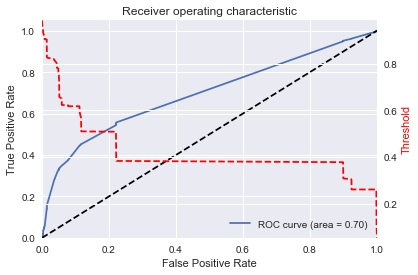

In [168]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
 
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])
 
plt.show()

### Final Model Evaluation

### Model Evaluation:

- we want to minimize homes being misclassified as unoccupied when they are really occupied
- this means we want to maximize the precision of 0 (unoccupied) as that minimizes the statement above
- False Negative of 0 means a home is classified as being occupied but is really unoccupied

<img src="Precisionrecall.png",width=300,height=300>

In [105]:
predictions = r_tree_tuned.predict(X_test)
predict_probability = r_tree_tuned.predict_proba(X_test)[:,1]

In [106]:
accuracy(y_test, predictions)

0.8917931566760998

In [107]:
def bool_to_num(v):
    if v == 'True':
        return '1'
    elif v == 'False':
        return '0'
    else:
        return v

In [108]:
predictions_w_threshold = np.vectorize(bool_to_num)(predict_probability>optimal_threshold).astype(int)

In [109]:
accuracy(y_test, predictions_w_threshold)

0.8923591458708515

In [110]:
pct_class_unocc_homes_accually_occ(y_test, predictions)

0.31716341212744092

In [111]:
print(roc_auc_score(y_test, predictions))

0.878267652914


In [112]:
print(roc_auc_score(y_test, predictions_w_threshold))

0.87842797954


## Dense Neural Network

In [169]:
dnn_keras_model = models.Sequential()
dnn_keras_model.add(layers.Dense(units=10, input_dim=5, activation='relu'))
dnn_keras_model.add(layers.Dense(units=10, input_dim=10, activation='relu'))
dnn_keras_model.add(layers.Dense(units=2, activation='softmax'))

In [170]:
opt = SGD(lr=0.01)
dnn_keras_model.compile(optimizer= opt,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [171]:
scaler = MinMaxScaler()

In [172]:
scaled_x_train = scaler.fit_transform(X_resampled)

In [173]:
scaled_x_test = scaler.fit_transform(X_test)

In [174]:
dnn_keras_model.fit(scaled_x_train,y_resampled,epochs=10)

Epoch 1/10
15102/15102 [==============================] - 1s - loss: 0.6376 - acc: 0.6516     
Epoch 2/10
15102/15102 [==============================] - 0s - loss: 0.6200 - acc: 0.6556     
Epoch 3/10
15102/15102 [==============================] - 0s - loss: 0.6175 - acc: 0.6604     
Epoch 4/10
15102/15102 [==============================] - 0s - loss: 0.6164 - acc: 0.6601     
Epoch 5/10
15102/15102 [==============================] - 0s - loss: 0.6157 - acc: 0.6602     
Epoch 6/10
15102/15102 [==============================] - 0s - loss: 0.6153 - acc: 0.6600     
Epoch 7/10
15102/15102 [==============================] - 0s - loss: 0.6149 - acc: 0.6601     
Epoch 8/10
15102/15102 [==============================] - 0s - loss: 0.6148 - acc: 0.6602     
Epoch 9/10
15102/15102 [==============================] - 0s - loss: 0.6147 - acc: 0.6602     
Epoch 10/10
15102/15102 [==============================] - 0s - loss: 0.6146 - acc: 0.6604     


In [175]:
predictions = dnn_keras_model.predict_classes(scaled_x_test)

5952/6552 [==========================>...] - ETA: 0s

In [176]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.78      0.88      0.83      4545
          1       0.62      0.44      0.52      2007

avg / total       0.73      0.75      0.73      6552



In [177]:
print(roc_auc_score(y_test, predictions))

0.661188809464


## Read in full data

In [124]:
data_full = '../data/OccModel_FittingFullData_20170922/'

#### DTE data

In [125]:
dte_full_df = pd.read_csv(data_full + 'DTE_ActiveGasElectric_GeocoderMatches_20170920.txt')

In [126]:
dte_full_df = dte_full_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [127]:
### Deduplicate data
dte_full_df = dte_full_df.drop_duplicates()

In [128]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_full_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df = dte_full_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

In [129]:
len(dte_full_df)

186539

#### DWSD (Water Department) data

In [130]:
dwsd_full_df = pd.read_csv(data_full + 'DWSD_12Mo_20170825.csv')

In [131]:
dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', u'TWO', u'THREE', \
              u'FOUR', u'FIVE', u'SIX', u'SEVEN',u'EIGHT']] \
            = dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', \
                            u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',\
                            u'EIGHT']].apply(pandas_to_numeric)

In [132]:
dwsd_full_df['year_total'] = dwsd_full_df.NINE + dwsd_full_df.TEN + dwsd_full_df.ELEVEN + \
                             dwsd_full_df.TWELVE + dwsd_full_df.ONE + dwsd_full_df.TWO + \
                             dwsd_full_df.THREE + dwsd_full_df.FOUR + dwsd_full_df.FIVE + \
                             dwsd_full_df.SIX + dwsd_full_df.SEVEN + dwsd_full_df.EIGHT

In [133]:
dwsd_full_df = dwsd_full_df[['REPAIREDPARCELID', u'year_total']]

In [134]:
dwsd_full_df.columns = ['Ref_ID', 'year_total']

In [135]:
### sum water amounts of duplicate properties 
dwsd_full_df = dwsd_full_df.groupby(['Ref_ID'], as_index=False)[ u'year_total'].sum()

#### USPS / DFD (Fire Department) data

In [136]:
usps_full_df = pd.read_csv(data_full + 'DFD_USPS_20170829.csv')

In [137]:
usps_full_df.head()

,Account Name,Parcel ID,Property Class,USPS: Last Update,USPS: Vacancy Indicated,DFD Fire: Occurrence Date
0,2411 Wendell,20007595.,Residential-Structure,8/1/2017,No,8/19/2017
1,17208 Ohio,16033858.,Residential-Structure,8/1/2017,No,8/19/2017
2,60 E Euclid,01002534.,Residential-Structure,8/1/2017,No,8/19/2017
3,8154 W Lafayette,20002305.,Residential-Structure,8/1/2017,Yes,8/19/2017
4,16691 Fairmount Dr,21025509.001,Residential-Structure,8/1/2017,No,8/18/2017


In [138]:
usps_full_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date',]

In [139]:
### subset to residential data
usps_full_df = usps_full_df[usps_full_df['Property Class'] == 'Residential-Structure']

In [140]:
### create DFD fire dummy
usps_full_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_full_df['DFD Fire: Occurrence Date']]

In [141]:
### create USPS occupied dummy
usps_full_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_full_df['USPS: Vacancy Indicated']]

In [142]:
### Just keep variables we need
usps_full_df = usps_full_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [143]:
vote_full_df = pd.read_csv(data_full + 'QVF_Detroit_Geo_20170717.txt')

In [144]:
vote_full_df = vote_full_df[['Ref_ID']]
vote_full_df['vote_dummy'] = 1

In [145]:
vote_full_df = vote_full_df.drop_duplicates()

#### Address Data

In [146]:
addy_full_df = pd.read_csv(data_full + 'ResStructureParcelsAccountIDs_20170920.csv')

In [147]:
addy_full_df.head()

,Account ID,Parcel ID,Account Name,Property Ownership,Property Class
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure


In [148]:
### subset to residential data
addy_full_df = addy_full_df[addy_full_df['Property Class'] == 'Residential-Structure']

In [149]:
addy_full_df.columns = ['Account_ID', 'Ref_ID', 'Account_Name', 'Property_Ownership', 'Property_Class']

In [150]:
len(addy_full_df)

234869

### Merge Datasets together

In [151]:
# merge mcm data with usps / dfd data
merged_full = addy_full_df.merge(usps_full_df, how='left', on='Ref_ID')

In [152]:
#merge on voter (qvf) data
merged_full2 = merged_full.merge(vote_full_df, how='left', on='Ref_ID')

In [153]:
#fill in NaNs for vote_dummy
merged_full2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_full2['vote_dummy']]

In [154]:
#merge on dwsd data
merged_full3 = merged_full2.merge(dwsd_full_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_full3.fillna(value=0,inplace=True)

In [155]:
#merge on dte data
merged_full_final = merged_full3.merge(dte_full_df, how='left', on='Ref_ID')
merged_full_final.fillna(value=0,inplace=True)

In [156]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0


In [157]:
merged_full_final.columns

Index([         u'Account_ID',              u'Ref_ID',        u'Account_Name',
        u'Property_Ownership',      u'Property_Class',  u'fire_occured_dummy',
       u'usps_occupied_dummy',          u'vote_dummy',          u'year_total',
                 u'gas_dummy',      u'electric_dummy'],
      dtype='object')

## Applying Predictions to full dataset

In [158]:
X.columns

Index([ u'fire_occured_dummy', u'usps_occupied_dummy',          u'vote_dummy',
                u'year_total',      u'electric_dummy'],
      dtype='object')

In [159]:
merged_full_final.copy()[['fire_occured_dummy', u'usps_occupied_dummy', u'vote_dummy',
                u'year_total', u'electric_dummy']].head()

,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,electric_dummy
0,0.0,1.0,1,0.0,1.0
1,0.0,1.0,1,9400.0,0.0
2,0.0,1.0,1,2100.0,0.0
3,0.0,1.0,1,14700.0,0.0
4,0.0,1.0,1,3100.0,1.0


In [160]:
predictions_df = merged_full_final.copy()[['fire_occured_dummy', u'usps_occupied_dummy', u'vote_dummy',
                u'year_total', u'electric_dummy']]

In [161]:
merged_full_final['prediction_occupancy'] = r_tree_tuned.predict(predictions_df)
merged_full_final['prediction_occupancy_proba'] = r_tree_tuned.predict_proba(predictions_df)[:,1]

In [162]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy,prediction_occupancy,prediction_occupancy_proba
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0,1,0.786584
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0,1,1.000000
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0,1,1.000000
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0,1,1.000000
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0,1,0.983581


### Investigating Final Housing Statistics

#### Number of occupied homes in Detroit

In [163]:
len(merged_full_final)

234869

In [164]:
sum(merged_full_final.prediction_occupancy)

173150

In [165]:
sum(merged_full_final.prediction_occupancy) * 1.0 / len(merged_full_final)

0.73721947127973464

#### Number of occupied homes owned by DLBA

In [166]:
merged_full_final.groupby(['Property_Ownership'])['prediction_occupancy'].sum()

Property_Ownership
DLBA Owned                       3293
Former Property of Interest      2933
Formerly DLBA Owned               760
Non-DLBA Owned                 163824
Property of Interest             1363
Resolved via NAP                  613
Under Compliance                  364
Name: prediction_occupancy, dtype: int64

In [167]:
merged_full_final.groupby(['Property_Ownership'])['prediction_occupancy'].count()

Property_Ownership
DLBA Owned                      31146
Former Property of Interest      5311
Formerly DLBA Owned              1172
Non-DLBA Owned                 191132
Property of Interest             3159
Resolved via NAP                  938
Under Compliance                 2011
Name: prediction_occupancy, dtype: int64

In [174]:
3293*1.0 / 31146

0.10572786232582033

## Export Final Data

In [169]:
# to .csv
merged_full_final.to_csv('OPM_output_final.csv', sep='\t')

In [170]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy,prediction_occupancy,prediction_occupancy_proba
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0,1,0.786584
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0,1,1.000000
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0,1,1.000000
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0,1,1.000000
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0,1,0.983581


In [171]:
### export just DLBA properties
DLBA_final = merged_full_final[merged_full_final.Property_Ownership=='DLBA Owned']

In [172]:
DLBA_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy,prediction_occupancy,prediction_occupancy_proba
81,001j000000IfPCC,22125943.,12336 W Outer Drive,DLBA Owned,Residential-Structure,0.0,0.0,0,0.0,0.0,0.0,0,0.034756
92,001j000000IfP6q,22125925.,12200 W Outer Drive,DLBA Owned,Residential-Structure,0.0,0.0,0,0.0,0.0,0.0,0,0.034756
119,001j000000IfOzk,22125881.,11820 W Outer Drive,DLBA Owned,Residential-Structure,0.0,0.0,0,0.0,0.0,0.0,0,0.034756
131,001j000000IfOsq,22125854.,11614 W Outer Drive,DLBA Owned,Residential-Structure,0.0,0.0,0,0.0,0.0,0.0,0,0.034756
136,001j000000IfOr5,22125839.,11480 W Outer Drive,DLBA Owned,Residential-Structure,0.0,0.0,0,0.0,0.0,0.0,0,0.034756


In [173]:
DLBA_final.to_csv('OPM_output_final_DLBA.csv', sep='\t')